In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introducción
En esta notebook se plantea un modelo de LSTM autoencoder para identificar anomalias en la vibración de maquinas rotantes. El modelo trabaja con la vibración RMS, y la metrica utilizada para calificar a una anomalia es el error de reconstrucción MAE (Mean Absolute Error) entre la entrada y la salida del autoencoder. Se tomó como referencia el modelo de LSTM-AE dado originalmente en [1].

Se prueba el modelo desarrollado en un dataset estandar de vibraciones, de tres grupos de cuatro rodamientos en una maquina, generado por la NASA[2]. Este fue adaptado para este caso en particular, calculando los valores RMS del dataset original como se explica en la ultima sección de esta notebook. Se compararon los resultados con los de otras publicaciones presentadas en el mismo paper, para contrastar su comportamiento.

`[1]Sabtain Ahmad, Kevin Styp-Rekowski, Sasho Nedelkoski, Odej Kao, "Autoencoder-based Condition Monitoring and
Anomaly Detection Method for Rotating Machines", Distributed and Operating Systems, Enero 2021`

`[2] J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA`

`Autoencoder-based Condition Monitoring and Anomaly Detection Method for Rotating Machines [https://arxiv.org/pdf/2101.11539.pdf](https://arxiv.org/pdf/2101.11539.pdf)`

# Paquetes

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from tensorflow.random import set_seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model, Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import regularizers
%matplotlib inline
sns.set(color_codes=True)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(10)
set_seed(10)

# Datasets

Los dataset consisten en el valor global de vibración en el tiempo de diferentes máquinas. A su vez cada máquina puede tener uno o multiples puntos de medición. Por esto los archivos poseen TxN valores, siendo T la cantidad de muestras y N la cantidad de puntos de medición.

In [ ]:
#dataset_path = ''
#output_path = ''
datasets = os.listdir(dataset_path)
for dataset in datasets:
    print(dataset)

mach_47.csv
mach_47_on.csv
mach_36.csv
mach_49.csv
set_2_rms.csv
set_3_rms.csv
mach_49_on.csv
mach_36_on.csv
mach_60.csv
mach_60_on.csv
set_1_rms.csv


# Clase para encapsular código

In [ ]:
def autoencoder_model(X):
    model = Sequential()
    print((X.shape[1],X.shape[2]))
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True))
    model.add(LSTM(4, activation='relu',return_sequences=False))
    model.add(RepeatVector(X.shape[1]))
    model.add(LSTM(4, activation='relu',return_sequences=True))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(X.shape[2]))
    return model 

class LSTMAE:
    def __init__(self,datasetName,nTrain,nTest,nVal):
        self.name = datasetName.split('.')[0]
        self.data = pd.read_csv(os.path.join(dataset_path, datasetName))
        N = len(self.data)
        self.n_train = nTrain*N
        self.n_val= nTest*N
        self.n_test = nVal*N
        self.train=self.data[self.data.index <= self.n_train]
        self.val=self.data[ (self.data.index > self.n_train) & (self.data.index <= self.n_train+self.n_val)]
        self.test=self.data[self.data.index > self.n_train + self.n_val]
 
    def plotData(self):
        fig = plt.figure(figsize=(16,10))
        train = self.train.drop(columns=['Unnamed: 0','date'])
        val = self.val.drop(columns=['Unnamed: 0','date'])
        test = self.test.drop(columns=['Unnamed: 0','date'])

        display(self.data.head())

        axes = plt.plot(train)
        for i,ax in enumerate(axes):
            ax.set_label(f"{train.columns[i]} train")

        axes = plt.plot(val)
        for i,ax in enumerate(axes):
            ax.set_label(f"{val.columns[i]} val")

        axes = plt.plot(test)
        for i,ax in enumerate(axes):
            ax.set_label(f"{test.columns[i]} test")
 
        plt.title(self.name, fontsize=16)
        plt.xlabel('Samples')
        plt.ylabel('Amplitude RMS')
        plt.legend()
        plt.show()

    def preprocessData(self, b_size=128):
        self.scaler = MinMaxScaler()
        # Train scaler on train data
        self.X_train = self.scaler.fit_transform(self.train.drop(columns=['Unnamed: 0','date']))

        # Scale data
        self.X_val = self.scaler.transform(self.val.drop(columns=['Unnamed: 0','date']))
        self.X_test = self.scaler.transform(self.test.drop(columns=['Unnamed: 0','date']))
        self.X_full = self.scaler.transform(self.data.drop(columns=['Unnamed: 0','date']))

        n_input = 16 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
        
        self.n_input = n_input
        self.generator_train = TimeseriesGenerator(self.X_train, self.X_train, length=n_input, batch_size=b_size)
        self.generator_val = TimeseriesGenerator(self.X_val, self.X_val, length=n_input, batch_size=b_size)
        self.generator_test = TimeseriesGenerator(self.X_test, self.X_test, length=n_input, batch_size=b_size)# zeros?
        self.generator_full = TimeseriesGenerator(self.X_full, self.X_full, length=n_input, batch_size=b_size)
        Xshape =  self.generator_train[0][0].shape
        Yshape =  self.generator_train[0][1].shape
        print("X shape", Xshape)
        print("Y shape", Yshape)

    def buildModel(self):
        # create the autoencoder model
        self.model = autoencoder_model(self.generator_train[0][0])
        self.model.compile(optimizer='adam', loss='mae')
        self.model.summary()

    def trainModel(self,nb_epochs=100, percentile=99.9):
        # fit the model to the data
        nb_epochs = 200
        earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        self.history = self.model.fit(self.generator_train, \
                                      validation_data=self.generator_val, \
                                      epochs=nb_epochs, \
                                      callbacks=[earlyStop]).history
        
        # plot the training losses
        fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
        ax.plot(self.history['loss'], 'b', label='Train', linewidth=2)
        ax.plot(self.history['val_loss'], 'r', label='Validation', linewidth=2)
        ax.set_title('Model loss', fontsize=16)
        ax.set_ylabel('Loss (mae)')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper right')
        plt.show()

        # Plot MAE histogram to define threshold
        X_pred = self.model.predict(self.generator_train)
        scored = np.mean(np.abs(X_pred-self.X_train[self.n_input:]), axis = 1)
        sns.displot(scored, kde= True, color = 'blue')
        plt.title('Loss Distribution' + self.name, fontsize=16)
        plt.xlabel('MAE')
        plt.ylabel('Frequency')
        plt.title(self.name)
        self.loss_cut = np.percentile(scored, percentile)
        plt.plot([self.loss_cut, self.loss_cut], plt.ylim(), 'r')
        plt.show()

    def runInference(self,window_size=5):
        X_pred = self.model.predict(self.generator_full)
 
        self.scored = pd.DataFrame()
        self.scored['Loss_mae'] = np.mean(np.abs(X_pred-self.X_full[self.n_input:]), axis = 1)
        self.scored['Filtered mae'] =  self.scored['Loss_mae'].rolling(window_size, min_periods=1).mean()
        self.scored['Threshold'] = self.loss_cut
        self.scored['Anomaly'] = self.scored['Loss_mae'] > self.scored['Threshold']

        self.degradationPoint = np.argmax(self.scored['Filtered mae'] > self.loss_cut)
        print("Degradation point is sample number", self.degradationPoint)
        print(self.data['date'][self.degradationPoint])
        self.scored.head()
        fig = plt.figure(figsize=(16,10))
        plt.plot(self.scored['Loss_mae'][0:int(self.n_train)], label='train')
        plt.plot(self.scored['Loss_mae'][int(self.n_train):int(self.n_train+self.n_val)], label='validation')
        plt.plot(self.scored['Loss_mae'][int(self.n_train+self.n_val):], label='test')
        plt.plot(self.scored['Filtered mae'], label='Filtered MAE', color='black')
        plt.plot(self.scored['Threshold'], label='Filtered MAE', color='red')
        plt.xlabel('Samples')
        plt.ylabel('MAE')
        plt.title(self.name)
        plt.gca().vlines(self.degradationPoint,plt.ylim()[0],plt.ylim()[1],color='red',linestyle='dashed')
        plt.yscale('log')

   

# NASA

### Carga del dataset
Los porcentajes de train/val/test se eligieron de forma tal de tener la misma cantidad de puntos en cada caso, para los distintos tamaños de dataset.

In [ ]:
model1 = LSTMAE("set_1_rms.csv",0.25,0.05,0.7)

In [ ]:
model2 = LSTMAE("set_2_rms.csv",0.3,0.1,0.6)

In [ ]:
model3 = LSTMAE("set_3_rms.csv",0.1,0.05,0.85)

### Exploración del dataset

Se grafica cada dataset en el tiempo, donde cada muestra es un punto en el gráfico. 

Set 1

Numero de archivos: 2,156

Numero de canales: 8

- Rodamiento 1: Canal 1 y 2
- Rodamiento 2: Canal 3 y 4
- Rodamiento 3: Canal 5 y 6
- Rodamiento 4: Canal 7 y 8

Al final del test se produce una falla en la pista interior del rodamiento 3 y en las bolas del rodamiento 4. 


,Unnamed: 0,date,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,0,2003-10-22 12:06:24,0.145278,0.149495,0.157649,0.131115
1,1,2003-10-22 12:09:13,0.144473,0.150533,0.158325,0.130996
2,2,2003-10-22 12:14:13,0.145910,0.150944,0.160100,0.132416
3,3,2003-10-22 12:19:13,0.145861,0.150659,0.159839,0.133134
4,4,2003-10-22 12:24:13,0.146282,0.149823,0.160070,0.132285


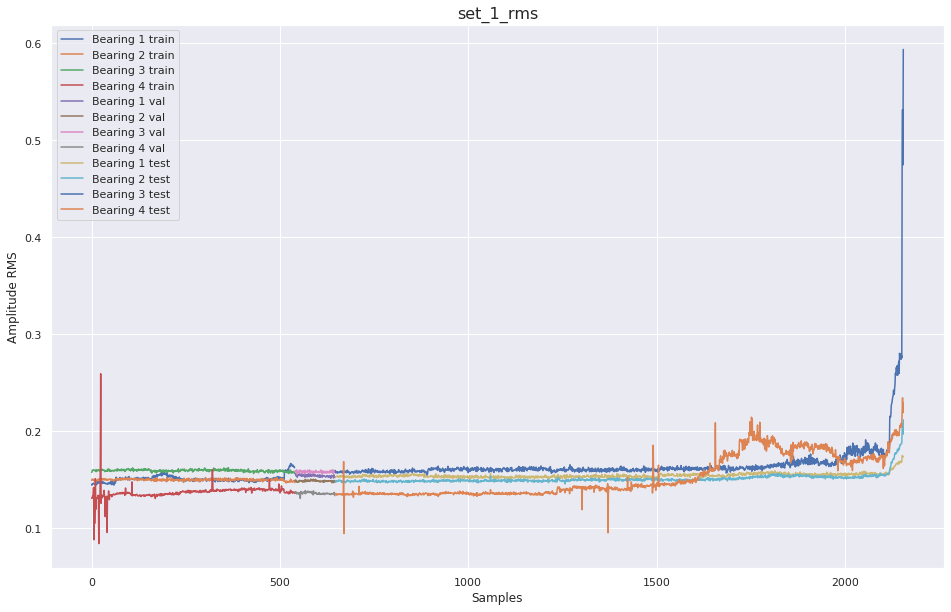

In [ ]:
model1.plotData()

Set 2

Numero de archivos: 984

Numero de canales: 4

- Rodamiento 1: Canal 1
- Rodamiento 2: Canal 2 
- Rodamiento 3: Canal 3
- Rodamiento 4: Canal 4

Al final del test se produce una falla en la pista exterior del rodamiento 1. 

,Unnamed: 0,date,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,0,2004-02-12 10:32:39,0.074180,0.090945,0.109403,0.054105
1,1,2004-02-12 10:42:39,0.075382,0.093417,0.109815,0.056102
2,2,2004-02-12 10:52:39,0.076228,0.093720,0.109864,0.056146
3,3,2004-02-12 11:02:39,0.078726,0.092949,0.110662,0.056808
4,4,2004-02-12 11:12:39,0.078475,0.095350,0.107507,0.056841


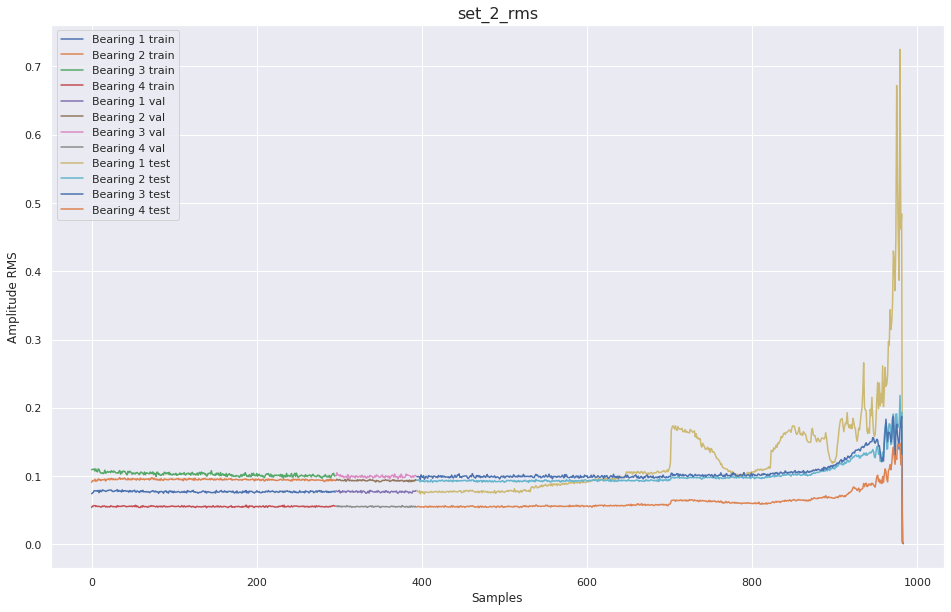

In [ ]:
model2.plotData()

Set 3

Numero de archivos: 4448

Numero de canales: 4

- Rodamiento 1: Canal 1
- Rodamiento 2: Canal 2 
- Rodamiento 3: Canal 3
- Rodamiento 4: Canal 4

Al final del test se produce una falla en la pista exterior del rodamiento 3. 

,Unnamed: 0,date,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,0,2004-03-04 09:27:46,0.079770,0.096704,0.066391,0.055493
1,1,2004-03-04 09:32:46,0.078677,0.092006,0.066287,0.053352
2,2,2004-03-04 09:42:46,0.079817,0.093431,0.069186,0.052704
3,3,2004-03-04 09:52:46,0.081084,0.092803,0.068637,0.054843
4,4,2004-03-04 10:02:46,0.079166,0.092830,0.067458,0.053912


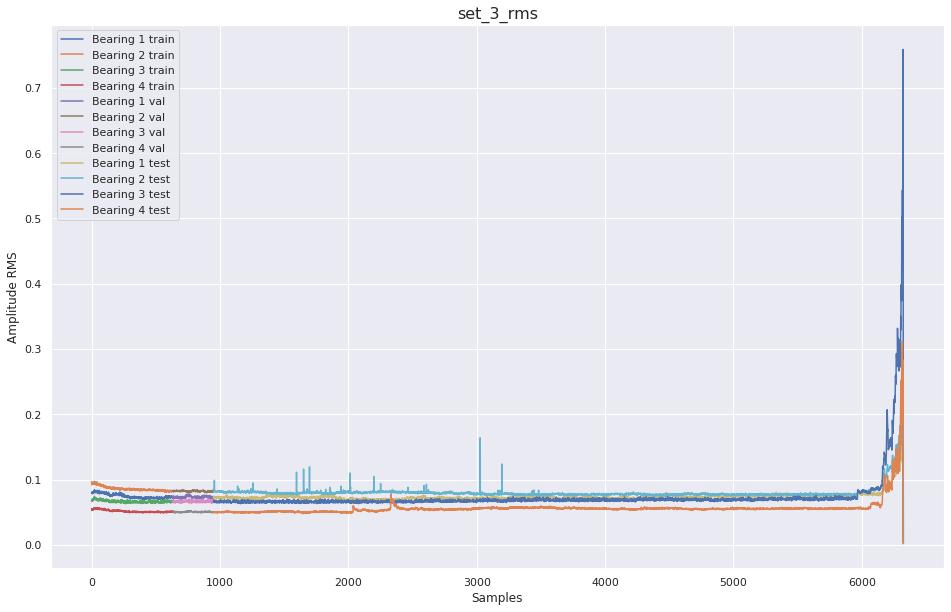

In [ ]:
model3.plotData()

### Preprocesamiento
Se normalizan los datos antes de realizar el entrenamiento 

In [ ]:
model1.preprocessData()

X shape (128, 16, 4)
Y shape (128, 4)


In [ ]:
model2.preprocessData()

X shape (128, 16, 4)
Y shape (128, 4)


In [ ]:
model3.preprocessData()

X shape (128, 16, 4)
Y shape (128, 4)


### Construcción del modelo

In [ ]:
model1.buildModel()

(16, 4)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 16, 16)            1344      
_________________________________________________________________
lstm_25 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 16, 4)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 16, 4)             144       
_________________________________________________________________
lstm_27 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 68        
Total params: 3,236
Trainable params: 3,236
Non-trainable params: 0
____________________________________________

In [ ]:
model2.buildModel()

(16, 4)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 16, 16)            1344      
_________________________________________________________________
lstm_29 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 16, 4)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 16, 4)             144       
_________________________________________________________________
lstm_31 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
Total params: 3,236
Trainable params: 3,236
Non-trainable params: 0
____________________________________________

In [ ]:
model3.buildModel()

(16, 4)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 16, 16)            1344      
_________________________________________________________________
lstm_33 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 16, 4)             0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 16, 4)             144       
_________________________________________________________________
lstm_35 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
Total params: 3,236
Trainable params: 3,236
Non-trainable params: 0
____________________________________________

### Entrenamiento

Epoch 1/200
5/5 [==============================] - 4s 165ms/step - loss: 0.4951 - val_loss: 0.4028
Epoch 2/200
5/5 [==============================] - 0s 34ms/step - loss: 0.4894 - val_loss: 0.3904
Epoch 3/200
5/5 [==============================] - 0s 37ms/step - loss: 0.4681 - val_loss: 0.3770
Epoch 4/200
5/5 [==============================] - 0s 35ms/step - loss: 0.4483 - val_loss: 0.3621
Epoch 5/200
5/5 [==============================] - 0s 36ms/step - loss: 0.4283 - val_loss: 0.3452
Epoch 6/200
5/5 [==============================] - 0s 36ms/step - loss: 0.4267 - val_loss: 0.3251
Epoch 7/200
5/5 [==============================] - 0s 38ms/step - loss: 0.3972 - val_loss: 0.2993
Epoch 8/200
5/5 [==============================] - 0s 36ms/step - loss: 0.3668 - val_loss: 0.2625
Epoch 9/200
5/5 [==============================] - 0s 36ms/step - loss: 0.3172 - val_loss: 0.2044
Epoch 10/200
5/5 [==============================] - 0s 34ms/step - loss: 0.2472 - val_loss: 0.1234
Epoch 11/200
5/5 [

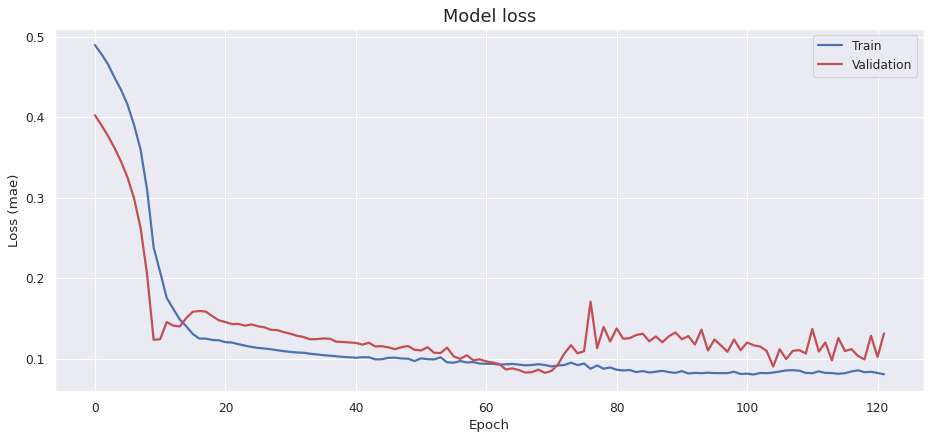

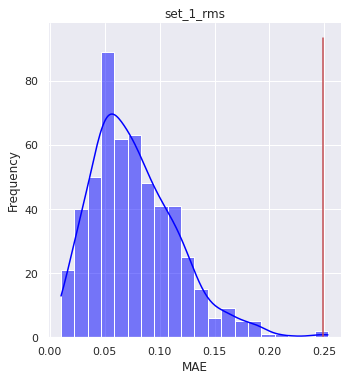

In [ ]:
model1.trainModel()

Epoch 1/200
3/3 [==============================] - 4s 332ms/step - loss: 0.5563 - val_loss: 0.4322
Epoch 2/200
3/3 [==============================] - 0s 58ms/step - loss: 0.5815 - val_loss: 0.4254
Epoch 3/200
3/3 [==============================] - 0s 58ms/step - loss: 0.5275 - val_loss: 0.4183
Epoch 4/200
3/3 [==============================] - 0s 50ms/step - loss: 0.5673 - val_loss: 0.4110
Epoch 5/200
3/3 [==============================] - 0s 55ms/step - loss: 0.5598 - val_loss: 0.4034
Epoch 6/200
3/3 [==============================] - 0s 48ms/step - loss: 0.5205 - val_loss: 0.3956
Epoch 7/200
3/3 [==============================] - 0s 49ms/step - loss: 0.5363 - val_loss: 0.3876
Epoch 8/200
3/3 [==============================] - 0s 47ms/step - loss: 0.4884 - val_loss: 0.3792
Epoch 9/200
3/3 [==============================] - 0s 62ms/step - loss: 0.4933 - val_loss: 0.3704
Epoch 10/200
3/3 [==============================] - 0s 55ms/step - loss: 0.4639 - val_loss: 0.3609
Epoch 11/200
3/3 [

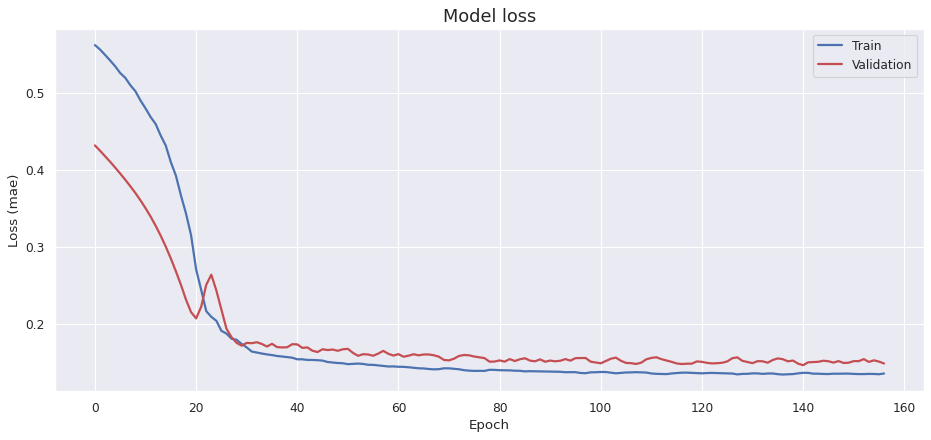

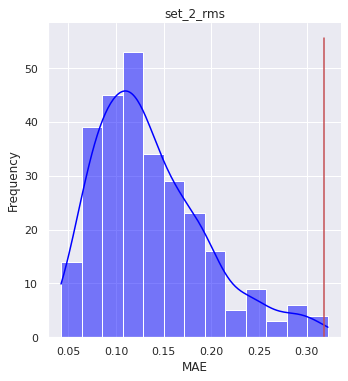

In [ ]:
model2.trainModel()

Epoch 1/200
5/5 [==============================] - 4s 165ms/step - loss: 0.4947 - val_loss: 0.2808
Epoch 2/200
5/5 [==============================] - 0s 42ms/step - loss: 0.3507 - val_loss: 0.2706
Epoch 3/200
5/5 [==============================] - 0s 41ms/step - loss: 0.3684 - val_loss: 0.2599
Epoch 4/200
5/5 [==============================] - 0s 38ms/step - loss: 0.3787 - val_loss: 0.2488
Epoch 5/200
5/5 [==============================] - 0s 41ms/step - loss: 0.3229 - val_loss: 0.2373
Epoch 6/200
5/5 [==============================] - 0s 43ms/step - loss: 0.3216 - val_loss: 0.2253
Epoch 7/200
5/5 [==============================] - 0s 47ms/step - loss: 0.4044 - val_loss: 0.2129
Epoch 8/200
5/5 [==============================] - 0s 39ms/step - loss: 0.3252 - val_loss: 0.2006
Epoch 9/200
5/5 [==============================] - 0s 38ms/step - loss: 0.2942 - val_loss: 0.1899
Epoch 10/200
5/5 [==============================] - 0s 40ms/step - loss: 0.2829 - val_loss: 0.1808
Epoch 11/200
5/5 [

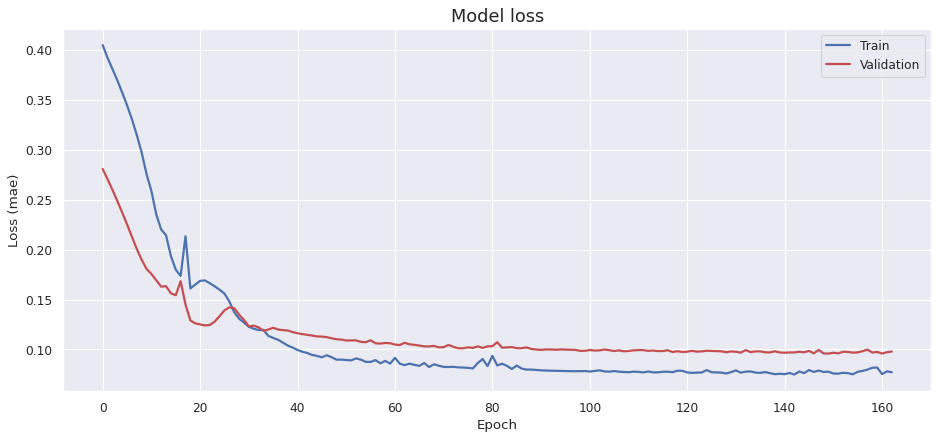

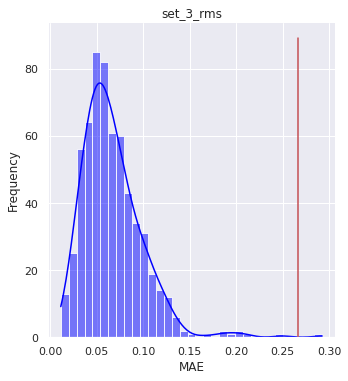

In [ ]:
model3.trainModel()

### Inferencia

Luego del entrenamiento se realiza la inferencia en los datos de test y se grafica el MAE obtenido junto al umbral de decisión.

Degradation point is sample number 1677
2003-11-21 12:08:36


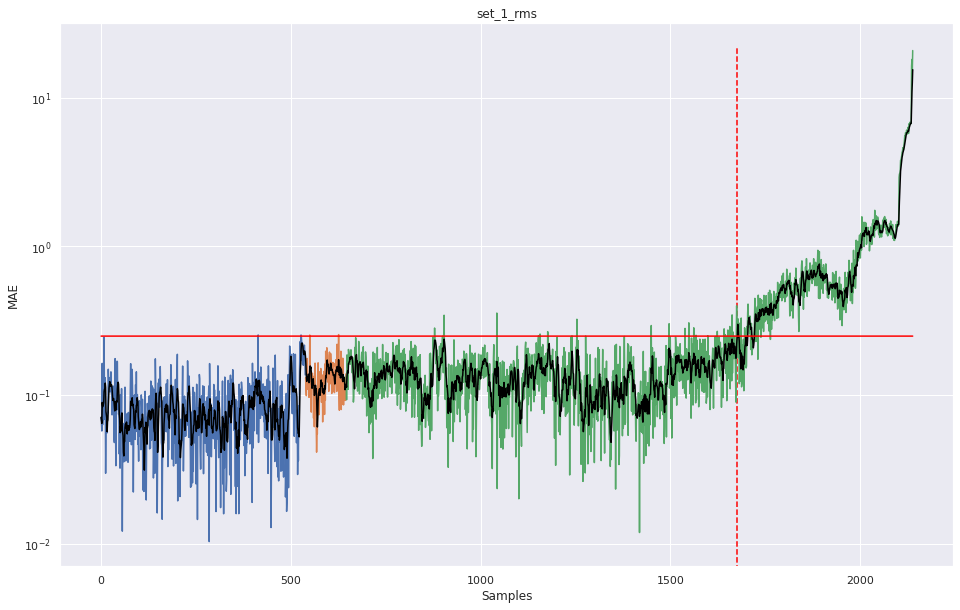

In [ ]:
model1.runInference()

Degradation point is sample number 519
2004-02-16 01:02:39


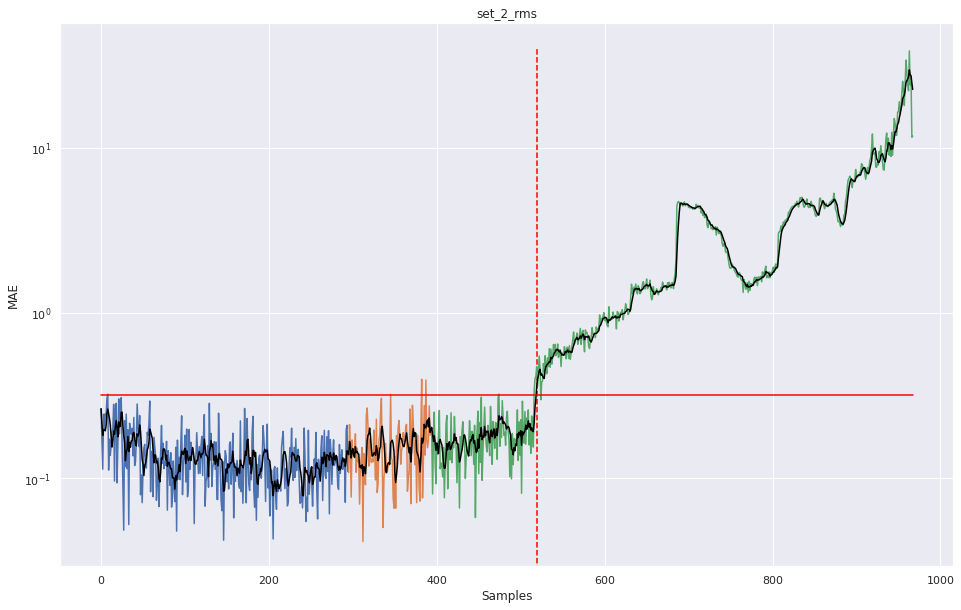

In [ ]:
model2.runInference()

Degradation point is sample number 2023
2004-03-18 14:45:20


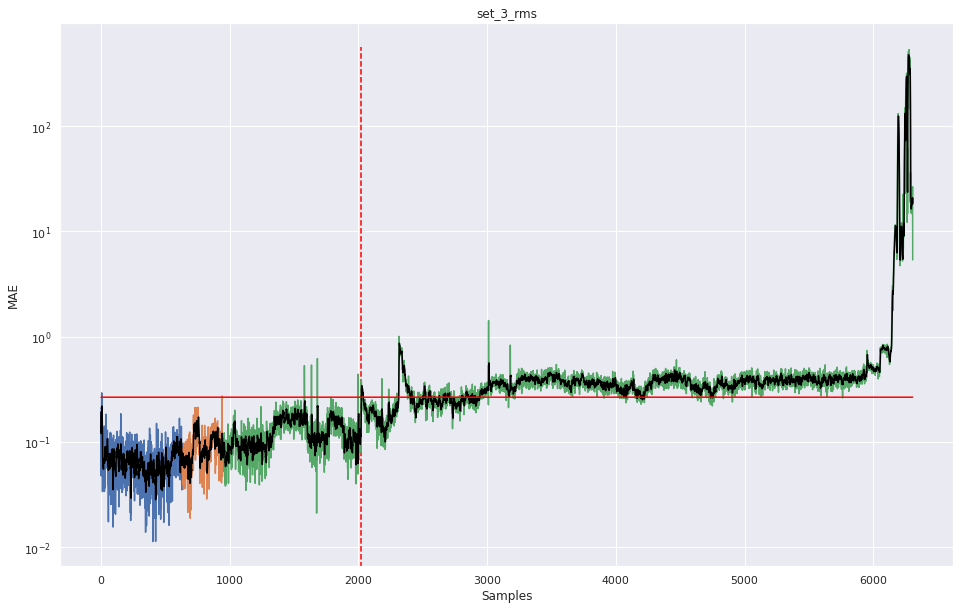

In [ ]:
model3.runInference()

# Resultados
---
## NASA
Se entrenó el modelo de LSTM-AE para cada máquina y se identificó el punto de iniciación de la falla. En la siguiente tabla se muestran los resultados obtenidos, comparados con otros presentadon en [1]. 

| Algoritmo    | S1B3 | S1B4 | S2B1 | S3B3       |
|--------------|------|------|------|------------|
| AEC          | 2027 | 1641 | 547  | 2367       |
| HMM-DPCA     | 2120 | 1760 | 539  | -          |
| HMM-PCA      | -    | 1780 | 538  | -          |
| RMS          | 2094 | 1730 | 539  | No detecta |
| MAS-Kurtosis | 1910 | 1650 | 710  | No detecta |
| VRCA         | -    | 1727 | -    | No detecta |
| LSTM-AE      | ->   | 1661 | 519  | 2317       |

Dado que el modelo analiza la máquina observando todos sus puntos de medición en conjunto (y no cada *Bearing* en particular), en el caso del Set 1 se identifica el comienzo de la falla en el momento que falla el rodamiento 4 (S1B4).


[1] *An Automated Auto-encoder Correlation-based Health-Monitoring and
Prognostic Method for Machine Bearings
Ramin M. Hasani, Guodong Wang and Radu Grosu - 18 Mar 2017*




In [ ]:
#@title Progress Bar
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max)) 

# Armado del dataset RMS NASA

A partir del dataset público provisto por la NASA se generó uno secundario. El dataset original contiene mediciones de vibración en crudo de 20480 muestras para cada rodamiento, por lo que para hacerlo compatible con el modelo planteado en esta notebook se procesó para tener la tendencia en el tiempo. Para esto, se calculó el valor RMS de cada medicion y se exportó a un csv. 

**Código comentado para no generar el dataset cada vez que se ejecuta la notebook**

In [ ]:
# dataset_path = ''#complete with path

# out = display(progress(0, 100), display_id=True)
# merged_data = pd.DataFrame()

# N = len(os.listdir(dataset_path))
# for i,filename in enumerate(os.listdir(dataset_path)):
#     out.update(progress(i/N*100, 100))
#     raw_vector = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')

#     raw_vector = np.array(raw_vector)
#     if raw_vector.shape[1] == 8:
#         for i in range(4):
#             raw_vector[:,i] = np.mean(raw_vector[:,2*i:2*i+1], axis=1)
#         raw_vector = raw_vector[:,0:4]

#     dataset_rms = np.sqrt(np.mean(np.array(raw_vector)**2,axis=0))
#     dataset_rms = pd.DataFrame(dataset_rms.reshape(1,4))
#     dataset_rms.index = [filename]
#     merged_data = merged_data.append(dataset_rms)

# merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']